In [ ]:
!pip install -q pandas tqdm

import os
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import files, drive

print("Colab environment ready.")


Colab environment ready.


In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print("Uploaded file:", fn)


Saving 10k_ecommerce_messy_dataset.csv to 10k_ecommerce_messy_dataset.csv
Uploaded file: 10k_ecommerce_messy_dataset.csv


In [ ]:
# If you used files.upload() above, set input_path to uploaded filename:
input_path = list(uploaded.keys())[0]


In [ ]:
# ===== Cell: Full Corrected Preprocessing Pipeline =====
# Make sure you set:
#   input_path = "/content/your_input.csv"
#   output_path = "/content/your_output_cleaned.csv"
# before running this cell.

import pandas as pd
import numpy as np
import re
from datetime import datetime

# --- Helper functions -------------------------------------------------------
def clean_whitespace(x):
    if pd.isna(x) or x == "":
        return np.nan
    return str(x).strip()

def parse_age(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s_no_space = s.replace(" ", "")
    if s_no_space.isdigit():
        val = int(s_no_space)
        return val if 5 <= val <= 120 else np.nan
    m = re.search(r"(\d{1,3})", s)
    if m:
        val = int(m.group(1))
        return val if 5 <= val <= 120 else np.nan
    return np.nan

def parse_currency(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # Remove commas and common non-numeric characters (keep digits, dot, minus)
    s = s.replace(",", "")
    s = re.sub(r"[^\d\.\-]", "", s)
    if s == "":
        return np.nan
    try:
        return float(s)
    except:
        return np.nan

def parse_date(x):
    # Robust date parsing: try explicit known formats first, then fallback to to_datetime with dayfirst=True
    if pd.isna(x):
        return pd.NaT
    s = str(x).strip()
    if s == "":
        return pd.NaT
    formats = ["%Y-%m-%d", "%d/%m/%Y", "%m-%d-%Y", "%b %d, %Y", "%d-%b-%Y", "%d-%m-%Y", "%Y/%m/%d"]
    for fmt in formats:
        try:
            return pd.to_datetime(s, format=fmt, errors="raise")
        except Exception:
            pass
    # Fallback - try pandas parser with dayfirst=True to handle d/m/Y common formats
    dt = pd.to_datetime(s, dayfirst=True, errors="coerce")
    return dt

def parse_quantity(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # if direct integer
    if s.isdigit():
        return int(s)
    m = re.search(r"(\d+)", s)
    if m:
        return int(m.group(1))
    return np.nan

def parse_returned(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {"1","y","yes","true","t"}:
        return 1
    if s in {"0","n","no","false","f"}:
        return 0
    return np.nan

def parse_active(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {"1","yes","active","true","y","t"}:
        return 1
    if s in {"0","no","inactive","false","n","f"}:
        return 0
    return np.nan

# --- Safety check: input_path / output_path must be defined by user --------------
try:
    input_path
    output_path
except NameError:
    raise RuntimeError("Please set variables `input_path` and `output_path` before running this cell.")

# 1) Load raw CSV as strings to inspect dirty values
df = pd.read_csv(input_path, dtype=str, keep_default_na=False, na_values=["", "NA", "NaN", None])
orig_len = len(df)
print(f"Loaded rows: {orig_len}")

# 2) Clean + parse columns
# name
df["name"] = df.get("name").apply(clean_whitespace).fillna("Unknown")

# age
df["age_clean"] = df.get("age").apply(parse_age).astype("float")

# gender
def clean_gender(x):
    if pd.isna(x) or str(x).strip()=="":
        return "Unknown"
    s = str(x).strip().lower()
    if s in {"m","male"}:
        return "Male"
    if s in {"f","female"}:
        return "Female"
    return "Other"
df["gender_clean"] = df.get("gender").apply(clean_gender)

# dates
df["signup_date_parsed"] = df.get("signup_date").apply(parse_date)
df["order_date_parsed"] = df.get("order_date").apply(parse_date)

# income
df["income_clean"] = df.get("income").apply(parse_currency)

# country, product_category
df["country_clean"] = df.get("country").apply(clean_whitespace).fillna("Unknown")
df["product_category_clean"] = df.get("product_category").apply(clean_whitespace).fillna("Unknown")

# order id
df["order_id_clean"] = df.get("order_id").apply(clean_whitespace)

# purchase_amount numeric
df["purchase_amount_clean"] = pd.to_numeric(df.get("purchase_amount"), errors="coerce").astype("float")

# quantity
df["quantity_clean"] = df.get("quantity").apply(parse_quantity).astype("float")

# payment method
df["payment_method_clean"] = df.get("payment_method").apply(clean_whitespace).fillna("Unknown")

# returned / is_active
df["returned_clean"] = df.get("returned").apply(parse_returned)
df["is_active_clean"] = df.get("is_active").apply(parse_active)

# feedback: strip whitespace using .str (vectorized) and convert empty to NaN
df["feedback_clean"] = df.get("feedback").astype("string").str.strip()
df.loc[df["feedback_clean"] == "", "feedback_clean"] = pd.NA
# ensure pandas NA type -> convert to Python NaN for further numeric ops if needed
df["feedback_clean"] = df["feedback_clean"].replace({pd.NA: np.nan})

# 3) Duplicates: drop exact duplicates and duplicate order_id where present
before_dup = len(df)
df = df.drop_duplicates()
if "order_id_clean" in df.columns:
    # remove duplicate orders keeping the first
    df = df[~((df["order_id_clean"].notna()) & (df.duplicated(subset=["order_id_clean"], keep="first")))]
after_dup = len(df)
print(f"Dropped {before_dup - after_dup} duplicates (exact + order_id-based).")

# 4) Imputation & outlier handling
# Age -> median (robust)
if df["age_clean"].dropna().shape[0] > 0:
    median_age = int(np.nanmedian(df["age_clean"]))
else:
    median_age = 30
df["age_clean"] = df["age_clean"].fillna(median_age)

# Income -> median fallback
if df["income_clean"].dropna().shape[0] > 0:
    median_income = float(np.nanmedian(df["income_clean"]))
else:
    median_income = 0.0
df["income_clean"] = df["income_clean"].fillna(median_income)

# Purchase: flag negatives, set negatives to NaN and impute with median; cap extreme outliers
df["purchase_negative_flag"] = df["purchase_amount_clean"] < 0
df.loc[df["purchase_negative_flag"] == True, "purchase_amount_clean"] = np.nan

if df["purchase_amount_clean"].dropna().shape[0] > 0:
    median_purchase = float(np.nanmedian(df["purchase_amount_clean"]))
else:
    median_purchase = 0.0
df["purchase_amount_clean"] = df["purchase_amount_clean"].fillna(median_purchase)

# Cap at 99.5th percentile
cap = df["purchase_amount_clean"].quantile(0.995)
df["purchase_amount_capped"] = df["purchase_amount_clean"].clip(upper=cap)

# Quantity: fill NaN with median or 1, ensure >=1
if df["quantity_clean"].dropna().shape[0] > 0:
    median_qty = int(np.nanmedian(df["quantity_clean"].dropna()))
else:
    median_qty = 1
df["quantity_clean"] = df["quantity_clean"].fillna(median_qty).astype(int)
df.loc[df["quantity_clean"] <= 0, "quantity_clean"] = 1

# returned / is_active: fill NaN with 0
df["returned_clean"] = df["returned_clean"].fillna(0).astype(int)
df["is_active_clean"] = df["is_active_clean"].fillna(0).astype(int)

# 5) Derived feature
df["order_revenue"] = df["purchase_amount_capped"] * df["quantity_clean"]

# 6) Final cleaned DataFrame & type casting
clean_cols = [
    "user_id","name","age_clean","gender_clean","signup_date_parsed","order_date_parsed",
    "income_clean","country_clean","product_category_clean","order_id_clean",
    "purchase_amount_capped","quantity_clean","order_revenue","payment_method_clean",
    "returned_clean","feedback_clean","is_active_clean"
]
clean_df = df[clean_cols].copy()
clean_df = clean_df.rename(columns={
    "age_clean":"age","gender_clean":"gender","signup_date_parsed":"signup_date","order_date_parsed":"order_date",
    "income_clean":"income","country_clean":"country","product_category_clean":"product_category",
    "order_id_clean":"order_id","purchase_amount_capped":"purchase_amount","quantity_clean":"quantity",
    "payment_method_clean":"payment_method","returned_clean":"returned","feedback_clean":"feedback",
    "is_active_clean":"is_active"
})

# Type casts (safe casting with coercion)
clean_df["user_id"] = pd.to_numeric(clean_df["user_id"], errors="coerce").fillna(-1).astype(int)
clean_df["age"] = pd.to_numeric(clean_df["age"], errors="coerce").fillna(median_age).astype(int)
clean_df["income"] = pd.to_numeric(clean_df["income"], errors="coerce").fillna(median_income).astype(float)
clean_df["purchase_amount"] = pd.to_numeric(clean_df["purchase_amount"], errors="coerce").fillna(median_purchase).astype(float)
clean_df["quantity"] = pd.to_numeric(clean_df["quantity"], errors="coerce").fillna(median_qty).astype(int)
clean_df["order_revenue"] = pd.to_numeric(clean_df["order_revenue"], errors="coerce").fillna(0.0).astype(float)
clean_df["returned"] = pd.to_numeric(clean_df["returned"], errors="coerce").fillna(0).astype(int)
clean_df["is_active"] = pd.to_numeric(clean_df["is_active"], errors="coerce").fillna(0).astype(int)

# 7) Save cleaned CSV
clean_df.to_csv(output_path, index=False)
print(f"Saved cleaned dataset to: {output_path}")

# 8) Summary prints
print("\n--- Summary (cleaned) ---")
print("Rows original:", orig_len, "Rows after cleaning:", len(clean_df), "Duplicates removed:", orig_len - len(clean_df))
print("Age (min, median, max):", clean_df["age"].min(), clean_df["age"].median(), clean_df["age"].max())
print("Income (min, median, 99pct):", clean_df["income"].min(), clean_df["income"].median(), clean_df["income"].quantile(0.99))
print("Purchase (min, median, 99.5pct):", clean_df["purchase_amount"].min(), clean_df["purchase_amount"].median(), clean_df["purchase_amount"].quantile(0.995))
print("\nTop countries:\n", clean_df["country"].value_counts().head(10))
print("\nTop product categories:\n", clean_df["product_category"].value_counts().head(10))
print("\nTop payment methods:\n", clean_df["payment_method"].value_counts().head(10))

# Show head of cleaned data
clean_df.head(10)


Loaded rows: 10050
Dropped 99 duplicates (exact + order_id-based).
Saved cleaned dataset to: cleaned_data.csv

--- Summary (cleaned) ---
Rows original: 10050 Rows after cleaning: 9951 Duplicates removed: 99
Age (min, median, max): 18 46.0 75
Income (min, median, 99pct): 10036.66 129973.005 247263.0
Purchase (min, median, 99.5pct): 0.0 23684.855000000003 73864878.505625

Top countries:
 country
USA          1030
Canada       1016
France       1013
UAE          1007
UK           1006
Australia     990
Singapore     981
India         966
Brazil        953
Germany       930
Name: count, dtype: int64

Top product categories:
 product_category
Electronics       1048
Home & Kitchen    1038
Health            1024
Groceries         1010
Sports             996
Toys               994
Clothing           979
Beauty             978
Automotive         957
Books              927
Name: count, dtype: int64

Top payment methods:
 payment_method
Wallet              1434
PayPal              1432
NetBanking

,user_id,name,age,gender,signup_date,order_date,income,country,product_category,order_id,purchase_amount,quantity,order_revenue,payment_method,returned,feedback,is_active
0,8777,Rahul Nair,25,Male,2020-02-06,2020-03-06,38347.650,France,Books,ORD-519516,0.00,2,0.000000e+00,UPI,0,Package damaged,1
1,2200,Ritu Das,18,Male,2019-07-23,2019-08-09,181409.000,France,Home & Kitchen,ORD-699618,23740.85,3,7.122255e+04,Credit Card,1,Excellent,0
2,9597,Sameer Rao,56,Male,2024-05-22,2024-05-26,107931.000,USA,Books,ORD-341103,45591142.18,10,4.559114e+08,PayPal,0,Excellent,0
3,8491,Arjun Singh,22,Female,2019-08-03,2019-08-14,90955.000,Germany,Electronics,ORD-971881,30150.86,4,1.206034e+05,NetBanking,0,Loved it 😊,1
4,3315,Sana Singh,55,Male,2022-05-14,2022-06-18,215902.490,UAE,Electronics,ORD-471651,40368.02,2,8.073604e+04,PayPal,0,Package damaged,0
5,3890,Anika Reddy,50,Female,2022-02-18,2022-02-25,144324.000,Canada,Books,ORD-399383,5700.47,1,5.700470e+03,Wallet,0,Bad quality,0
6,3750,Rohit Singh,48,Female,2021-01-09,2021-02-25,182964.000,USA,Toys,ORD-267808,12644.83,6,7.586898e+04,Debit Card,0,Package damaged,0
7,705,Nisha Patel,34,Male,2022-07-14,2022-08-18,20522.000,Singapore,Sports,ORD-336064,17399.56,4,6.959824e+04,UPI,0,<NA>,0
8,2255,Rohit Iyer,61,Female,2023-11-02,2023-12-19,129973.005,India,Groceries,ORD-101319,5317.18,4,2.126872e+04,Debit Card,0,Loved it 😊,1
9,9604,Siddhant Mehta,63,Female,2023-11-06,2023-11-29,125503.000,Germany,Toys,ORD-752766,35247.12,10,3.524712e+05,PayPal,0,Package damaged,0


from matplotlib import pyplot as plt
_df_0['user_id'].plot(kind='hist', bins=20, title='user_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['income'].plot(kind='hist', bins=20, title='income')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['purchase_amount'].plot(kind='hist', bins=20, title='purchase_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('country').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('product_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('payment_method').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='user_id', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='age', y='income', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='income', y='purchase_amount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='purchase_amount', y='quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['signup_date']
  ys = series['user_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('signup_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('signup_date')
_ = plt.ylabel('user_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['signup_date']
  ys = series['user_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('signup_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('country')):
  _plot_series(series, series_name, i)
  fig.legend(title='country', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('signup_date')
_ = plt.ylabel('user_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['signup_date']
  ys = series['user_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('signup_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_category')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('signup_date')
_ = plt.ylabel('user_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['signup_date']
  ys = series['user_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('signup_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('payment_method')):
  _plot_series(series, series_name, i)
  fig.legend(title='payment_method', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('signup_date')
_ = plt.ylabel('user_id')

from matplotlib import pyplot as plt
_df_16['user_id'].plot(kind='line', figsize=(8, 4), title='user_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['income'].plot(kind='line', figsize=(8, 4), title='income')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['purchase_amount'].plot(kind='line', figsize=(8, 4), title='purchase_amount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['country'].value_counts()
    for x_label, grp in _df_20.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('country')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_category'].value_counts()
    for x_label, grp in _df_21.groupby('country')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('country')
_ = plt.ylabel('product_category')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['payment_method'].value_counts()
    for x_label, grp in _df_22.groupby('product_category')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('product_category')
_ = plt.ylabel('payment_method')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='user_id', y='gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['country'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='user_id', y='country', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['product_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='user_id', y='product_category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['payment_method'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='user_id', y='payment_method', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from google.colab import files
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
script_text = """# preprocessing_script.py
# (autogenerated)
"""
with open("preprocessing_script.py", "w") as f:
    f.write(script_text)
files.download("preprocessing_script.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("cleaned_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# CELL 1 → Upload or Load Cleaned Dataset

from google.colab import files
import pandas as pd

print("Upload your CLEANED CSV file (cleaned_data.csv)...")

uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Upload your CLEANED CSV file (cleaned_data.csv)...


Saving cleaned_data (1).csv to cleaned_data (1).csv


,user_id,name,age,gender,signup_date,order_date,income,country,product_category,order_id,purchase_amount,quantity,order_revenue,payment_method,returned,feedback,is_active
0,8777,Rahul Nair,25,Male,2020-02-06,2020-03-06,38347.65,France,Books,ORD-519516,0.00,2,0.000000e+00,UPI,0,Package damaged,1
1,2200,Ritu Das,18,Male,2019-07-23,2019-08-09,181409.00,France,Home & Kitchen,ORD-699618,23740.85,3,7.122255e+04,Credit Card,1,Excellent,0
2,9597,Sameer Rao,56,Male,2024-05-22,2024-05-26,107931.00,USA,Books,ORD-341103,45591142.18,10,4.559114e+08,PayPal,0,Excellent,0
3,8491,Arjun Singh,22,Female,2019-08-03,2019-08-14,90955.00,Germany,Electronics,ORD-971881,30150.86,4,1.206034e+05,NetBanking,0,Loved it 😊,1
4,3315,Sana Singh,55,Male,2022-05-14,2022-06-18,215902.49,UAE,Electronics,ORD-471651,40368.02,2,8.073604e+04,PayPal,0,Package damaged,0


In [ ]:
# CELL 2 → Basic Info

df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9951 entries, 0 to 9950
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           9951 non-null   int64  
 1   name              9951 non-null   object 
 2   age               9951 non-null   int64  
 3   gender            9951 non-null   object 
 4   signup_date       9934 non-null   object 
 5   order_date        9944 non-null   object 
 6   income            9951 non-null   float64
 7   country           9951 non-null   object 
 8   product_category  9951 non-null   object 
 9   order_id          9945 non-null   object 
 10  purchase_amount   9951 non-null   float64
 11  quantity          9951 non-null   int64  
 12  order_revenue     9951 non-null   float64
 13  payment_method    9951 non-null   object 
 14  returned          9951 non-null   int64  
 15  feedback          8179 non-null   object 
 16  is_active         9951 non-null   int64  


,user_id,age,income,purchase_amount,quantity,order_revenue,returned,is_active
count,9951.000000,9951.000000,9951.000000,9.951000e+03,9951.000000,9.951000e+03,9951.000000,9951.000000
mean,4998.337454,46.061401,129799.435642,8.879611e+05,5.427093,4.996889e+06,0.431112,0.427595
std,2886.756794,16.023147,62595.120727,7.035570e+06,2.860524,4.462958e+07,0.495257,0.494755
min,1.000000,18.000000,10036.660000,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000
25%,2500.500000,33.000000,84390.000000,1.077835e+04,3.000000,3.471649e+04,0.000000,0.000000
50%,4995.000000,46.000000,129973.005000,2.368486e+04,5.000000,9.808692e+04,0.000000,0.000000
75%,7496.500000,59.000000,175184.745000,3.698084e+04,8.000000,2.034299e+05,1.000000,1.000000
max,10000.000000,75.000000,249981.000000,7.396444e+07,10.000000,7.396444e+08,1.000000,1.000000


In [ ]:
# CELL 3 → Missing Values Check

df.isnull().sum()


,0
user_id,0
name,0
age,0
gender,0
signup_date,17
order_date,7
income,0
country,0
product_category,0
order_id,6


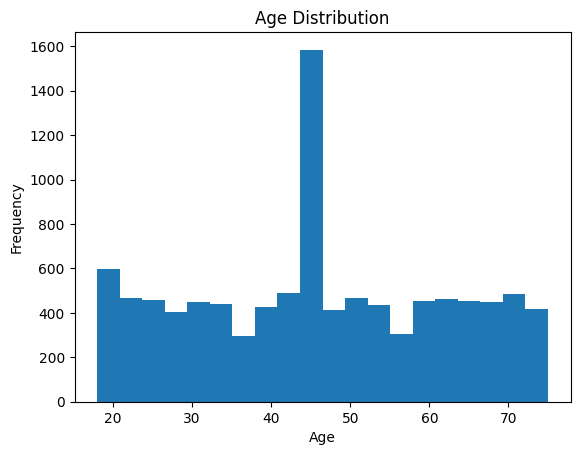

In [ ]:
# CELL 4 → Age Distribution

import matplotlib.pyplot as plt

plt.hist(df['age'], bins=20)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


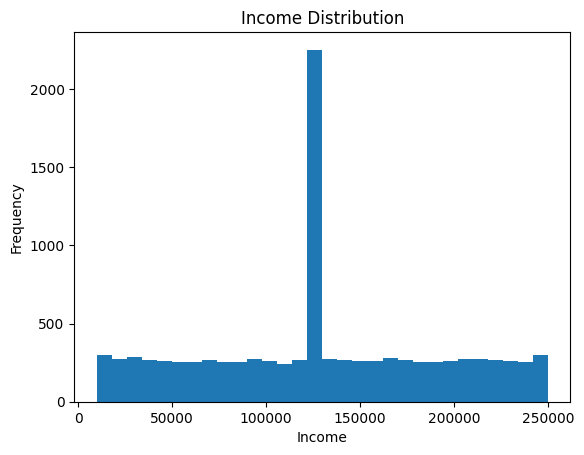

In [ ]:
# CELL 5 → Income Distribution

plt.hist(df['income'], bins=30)
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.show()


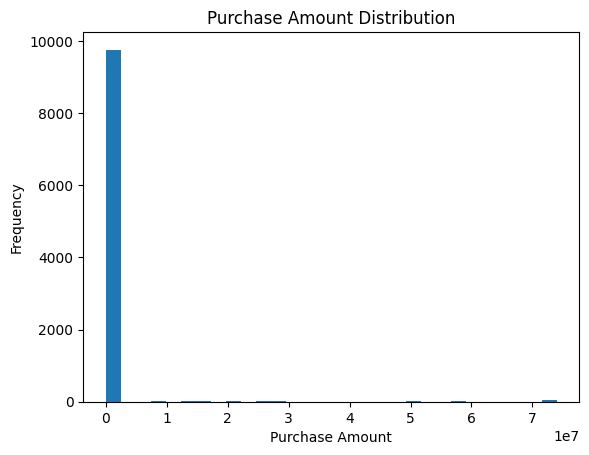

In [ ]:
# CELL 6 → Purchase Amount Distribution

plt.hist(df['purchase_amount'], bins=30)
plt.title("Purchase Amount Distribution")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.show()


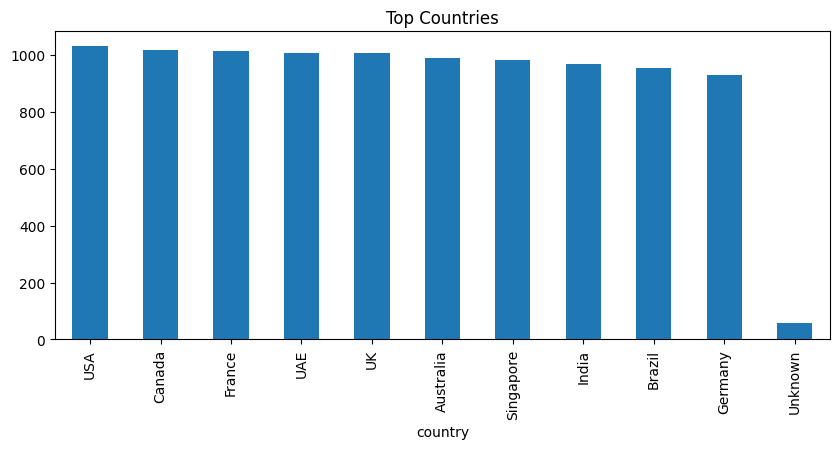

In [ ]:
# CELL 7 → Country-wise Customers

df['country'].value_counts().plot(kind='bar', figsize=(10,4))
plt.title("Top Countries")
plt.show()


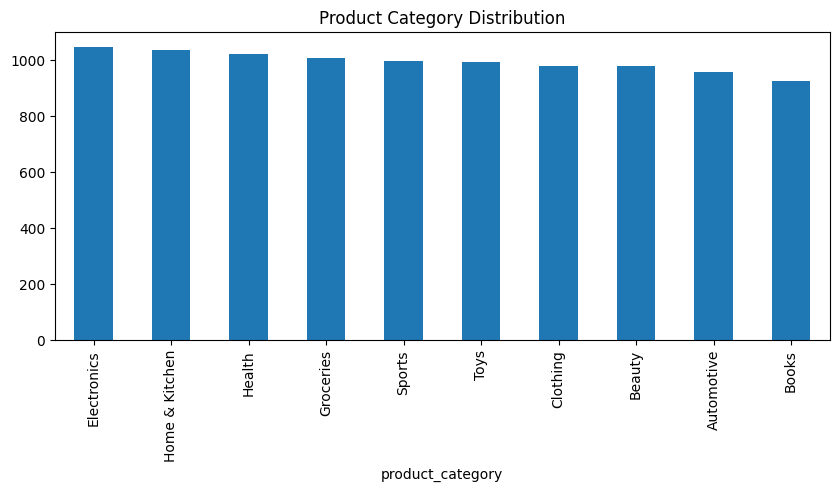

In [ ]:
# CELL 8 → Product Categories

df['product_category'].value_counts().plot(kind='bar', figsize=(10,4))
plt.title("Product Category Distribution")
plt.show()


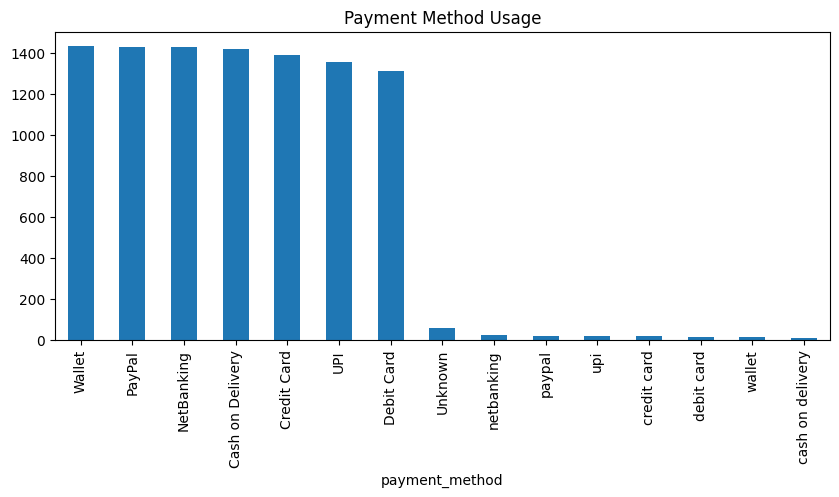

In [ ]:
# CELL 9 → Payment Methods

df['payment_method'].value_counts().plot(kind='bar', figsize=(10,4))
plt.title("Payment Method Usage")
plt.show()


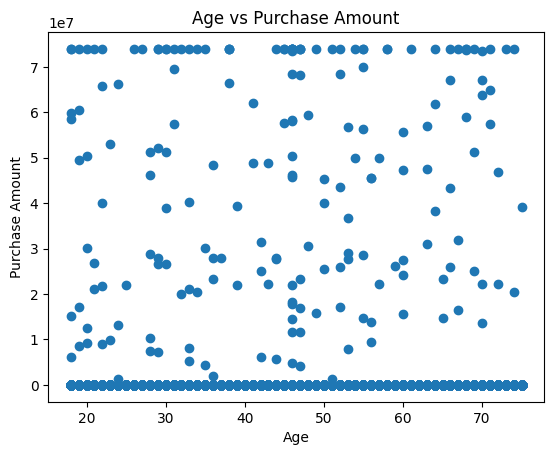

In [ ]:
# CELL 10 → Age vs Purchase

plt.scatter(df['age'], df['purchase_amount'])
plt.title("Age vs Purchase Amount")
plt.xlabel("Age")
plt.ylabel("Purchase Amount")
plt.show()


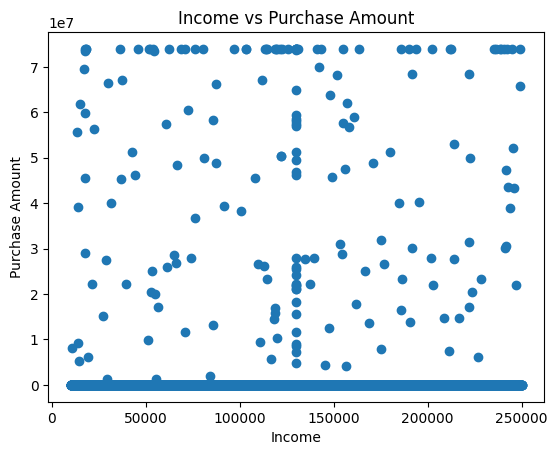

In [ ]:
# CELL 11 → Income vs Purchase

plt.scatter(df['income'], df['purchase_amount'])
plt.title("Income vs Purchase Amount")
plt.xlabel("Income")
plt.ylabel("Purchase Amount")
plt.show()


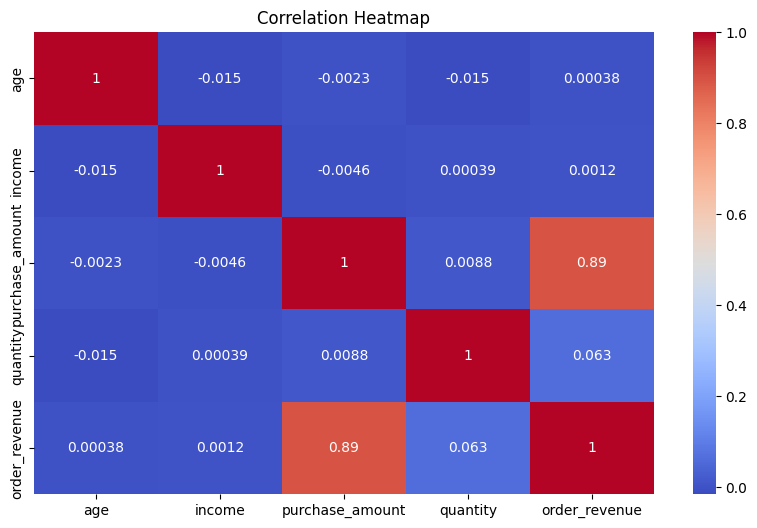

In [ ]:
# CELL 12 → Correlation Heatmap

import seaborn as sns
plt.figure(figsize=(10,6))

sns.heatmap(df[['age','income','purchase_amount','quantity','order_revenue']].corr(),
            annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap")
plt.show()


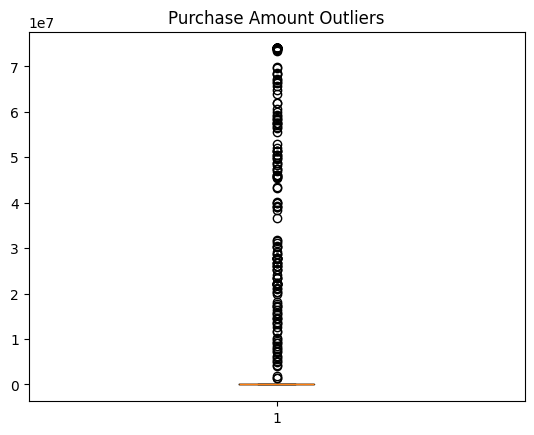

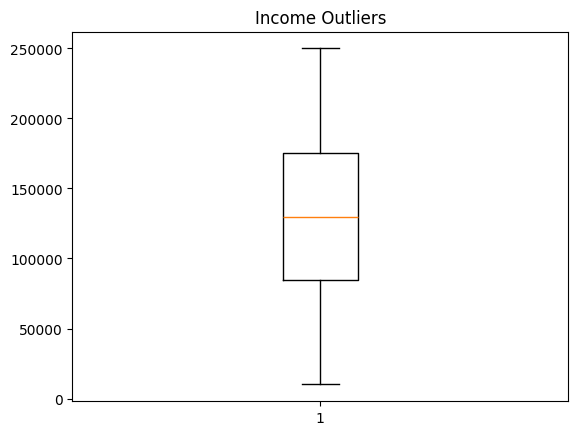

In [ ]:
# CELL 13 → Purchase Amount Outlier Boxplot

plt.boxplot(df['purchase_amount'])
plt.title("Purchase Amount Outliers")
plt.show()
# Income Outlier Boxplot
plt.boxplot(df['income'])
plt.title("Income Outliers")
plt.show()


In [ ]:
# CELL 14 → Save EDA-ready Data

df.to_csv("eda_ready_data.csv", index=False)

from google.colab import files
files.download("eda_ready_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving eda_ready_data.csv to eda_ready_data (1).csv


In [ ]:
import pandas as pd
df = pd.read_csv(list(uploaded.keys())[0])
df.head()


,user_id,name,age,gender,signup_date,order_date,income,country,product_category,order_id,purchase_amount,quantity,order_revenue,payment_method,returned,feedback,is_active
0,8777,Rahul Nair,25,Male,2020-02-06,2020-03-06,38347.65,France,Books,ORD-519516,0.00,2,0.000000e+00,UPI,0,Package damaged,1
1,2200,Ritu Das,18,Male,2019-07-23,2019-08-09,181409.00,France,Home & Kitchen,ORD-699618,23740.85,3,7.122255e+04,Credit Card,1,Excellent,0
2,9597,Sameer Rao,56,Male,2024-05-22,2024-05-26,107931.00,USA,Books,ORD-341103,45591142.18,10,4.559114e+08,PayPal,0,Excellent,0
3,8491,Arjun Singh,22,Female,2019-08-03,2019-08-14,90955.00,Germany,Electronics,ORD-971881,30150.86,4,1.206034e+05,NetBanking,0,Loved it 😊,1
4,3315,Sana Singh,55,Male,2022-05-14,2022-06-18,215902.49,UAE,Electronics,ORD-471651,40368.02,2,8.073604e+04,PayPal,0,Package damaged,0


In [ ]:
# ===== Colab cell: Generate EDA PDF report from eda_ready_data.csv =====
# Paste this into Colab (after you've uploaded eda_ready_data.csv) and run.

!pip install reportlab

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.utils import ImageReader
from google.colab import files

# ------------- CONFIG -------------
INPUT_CSV = "eda_ready_data.csv"      # your file (you uploaded earlier)
OUTPUT_PDF = "EDA_Report.pdf"
TMP_DIR = "/content/eda_tmp"
os.makedirs(TMP_DIR, exist_ok=True)

# ------------- Load data (safety check) -------------
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"File not found: {INPUT_CSV}. Please upload it first (use files.upload()).")

df = pd.read_csv(INPUT_CSV)
# Basic safety conversions if needed
numeric_cols = ["age","income","purchase_amount","quantity","order_revenue"]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ------------- Create charts (save PNGs) -------------
plots = []

# 1) Basic info text summary (we'll embed as paragraphs)
rows, cols = df.shape
median_age = int(df['age'].median()) if 'age' in df.columns else "N/A"
median_income = float(df['income'].median()) if 'income' in df.columns else "N/A"
median_purchase = float(df['purchase_amount'].median()) if 'purchase_amount' in df.columns else "N/A"

# 2) Age distribution
if 'age' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['age'].dropna(), bins=20)
    plt.title("Age Distribution")
    plt.xlabel("Age"); plt.ylabel("Count")
    p = os.path.join(TMP_DIR, "age_dist.png")
    plt.tight_layout(); plt.savefig(p); plt.close()
    plots.append(("Age distribution", p))

# 3) Income distribution
if 'income' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['income'].dropna(), bins=30)
    plt.title("Income Distribution")
    plt.xlabel("Income"); plt.ylabel("Count")
    p = os.path.join(TMP_DIR, "income_dist.png")
    plt.tight_layout(); plt.savefig(p); plt.close()
    plots.append(("Income distribution", p))

# 4) Purchase amount distribution
if 'purchase_amount' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['purchase_amount'].dropna(), bins=30)
    plt.title("Purchase Amount Distribution")
    plt.xlabel("Purchase Amount"); plt.ylabel("Count")
    p = os.path.join(TMP_DIR, "purchase_dist.png")
    plt.tight_layout(); plt.savefig(p); plt.close()
    plots.append(("Purchase amount distribution", p))

# 5) Boxplots for outliers (purchase & income)
if 'purchase_amount' in df.columns:
    plt.figure(figsize=(6,3))
    plt.boxplot(df['purchase_amount'].dropna(), vert=False)
    plt.title("Purchase Amount - Boxplot (outliers)")
    p = os.path.join(TMP_DIR, "purchase_box.png")
    plt.tight_layout(); plt.savefig(p); plt.close()
    plots.append(("Purchase amount boxplot", p))

if 'income' in df.columns:
    plt.figure(figsize=(6,3))
    plt.boxplot(df['income'].dropna(), vert=False)
    plt.title("Income - Boxplot (outliers)")
    p = os.path.join(TMP_DIR, "income_box.png")
    plt.tight_layout(); plt.savefig(p); plt.close()
    plots.append(("Income boxplot", p))

# 6) Top countries bar
if 'country' in df.columns:
    top_ct = df['country'].value_counts().head(10)
    plt.figure(figsize=(7,3))
    top_ct.plot(kind='bar')
    plt.title("Top Countries (by count)")
    plt.tight_layout()
    p = os.path.join(TMP_DIR, "country_bar.png"); plt.savefig(p); plt.close()
    plots.append(("Top countries", p))

# 7) Top product categories bar
if 'product_category' in df.columns:
    top_cat = df['product_category'].value_counts().head(12)
    plt.figure(figsize=(7,3))
    top_cat.plot(kind='bar')
    plt.title("Top Product Categories")
    plt.tight_layout()
    p = os.path.join(TMP_DIR, "category_bar.png"); plt.savefig(p); plt.close()
    plots.append(("Product categories", p))

# 8) Payment method bar
if 'payment_method' in df.columns:
    top_pay = df['payment_method'].value_counts().head(10)
    plt.figure(figsize=(7,3))
    top_pay.plot(kind='bar')
    plt.title("Payment Methods")
    plt.tight_layout()
    p = os.path.join(TMP_DIR, "payment_bar.png"); plt.savefig(p); plt.close()
    plots.append(("Payment methods", p))

# 9) Correlation heatmap (numeric)
num_for_corr = [c for c in numeric_cols if c in df.columns]
if len(num_for_corr) >= 2:
    plt.figure(figsize=(6,5))
    sns.heatmap(df[num_for_corr].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    p = os.path.join(TMP_DIR, "corr_heatmap.png"); plt.tight_layout(); plt.savefig(p); plt.close()
    plots.append(("Correlation heatmap", p))

# ------------- Build PDF with ReportLab -------------
styles = getSampleStyleSheet()
doc = SimpleDocTemplate(OUTPUT_PDF, pagesize=letter)
story = []

# Title
story.append(Paragraph("<b>Exploratory Data Analysis Report</b>", styles["Title"]))
story.append(Spacer(1, 12))

# Pre-format median values
formatted_median_income = f"{median_income:.2f}" if isinstance(median_income, (int, float)) else str(median_income)
formatted_median_purchase = f"{median_purchase:.2f}" if isinstance(median_purchase, (int, float)) else str(median_purchase)

# Summary paragraph
summary_html = f"""
<b>Dataset summary</b><br/>
Rows: {rows}<br/>
Columns: {cols}<br/>
Median age: {median_age}<br/>
Median income: {formatted_median_income}<br/>
Median purchase amount: {formatted_median_purchase}<br/>
"""
story.append(Paragraph(summary_html, styles["Normal"]))
story.append(Spacer(1, 12))

# Add each plot with heading
for title, img_path in plots:
    story.append(Paragraph(f"<b>{title}</b>", styles["Heading2"]))
    # Use ImageReader to be robust
    try:
        img = Image(img_path, width=450, height=260)
        story.append(img)
    except Exception as e:
        story.append(Paragraph(f"Could not load image: {img_path} ({e})", styles["Normal"]))
    story.append(Spacer(1, 12))

# Add a small notes section
notes = """
<b>Notes & next steps</b><br/>
- Missing values were already handled in preprocessing.<br/>
- Purchase_amount outliers were capped during preprocessing; review extreme values manually.<br/>
- Consider more visual breakdowns (time series by signup/order date) if required.<br/>
"""
story.append(Paragraph(notes, styles["Normal"]))

# Build PDF
doc.build(story)

# ------------- Provide download link -------------
print("PDF generated:", OUTPUT_PDF)
files.download(OUTPUT_PDF)

PDF generated: EDA_Report.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>